### EDA of the S&P500 dataset

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL, seasonal_decompose

In [20]:
ticker = "^GSPC"
df = yf.download(ticker,
                 start="2016-01-01",
                 end="2025-01-01",
                 progress=False)

s = df['Close'].resample('M').mean()

C:\Users\USER\AppData\Local\Temp\ipykernel_12072\1577716646.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker,
C:\Users\USER\AppData\Local\Temp\ipykernel_12072\1577716646.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  s = df['Close'].resample('M').mean()


In [21]:
stl = STL(s, seasonal=13, robust=True)
stl_res = stl.fit()

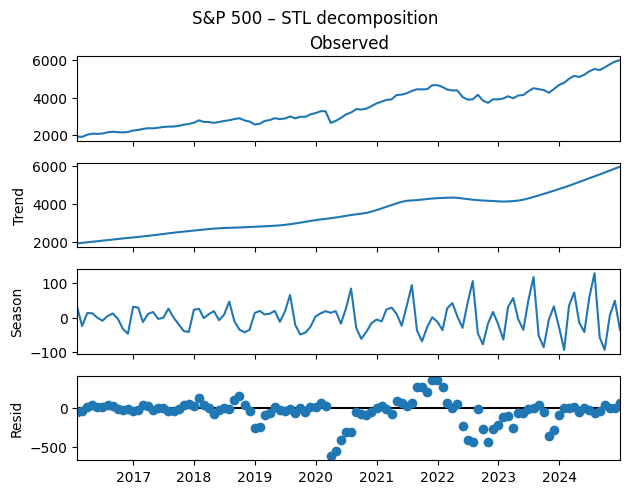

In [24]:
fig1 = stl_res.plot()
fig1.suptitle("S&P 500 – STL decomposition", y=1.02)
plt.show()

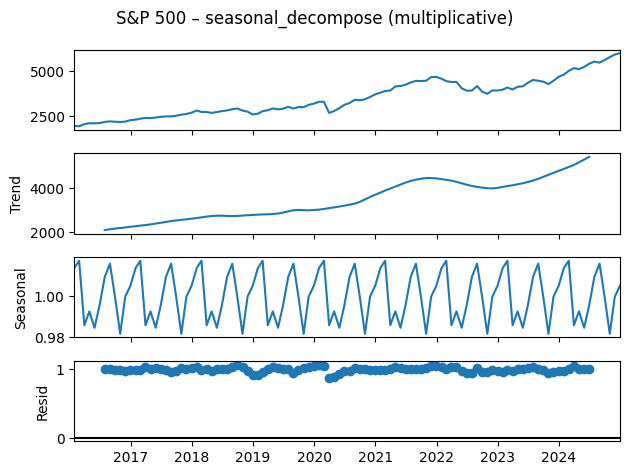

In [23]:
# Classic X-11–style additive or multiplicative decomposition
# works fine when seasonality is roughly constant over time
decomp = seasonal_decompose(s, model='multiplicative', period=12)
fig2 = decomp.plot()
fig2.suptitle("S&P 500 – seasonal_decompose (multiplicative)")
plt.tight_layout()
plt.show()

### Random walk testing

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

# suppose `s` is your monthly price series
adf_stat, pval, *_ = adfuller(s)
print("ADF p‐value:", pval) # fail to reject the null of a unit root

kpss_stat, pval, *_ = kpss(s, regression='c')
print("KPSS p‐value:", pval) # p ≪ 0.01, so strongly reject stationarity

ADF p‐value: 0.9925511968592353
KPSS p‐value: 0.01


C:\Users\USER\AppData\Local\Temp\ipykernel_12072\2214663674.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, pval, *_ = kpss(s, regression='c')


### EMH weak test

In [27]:
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox

r = s.pct_change().dropna()
lb_stat, lb_pval = acorr_ljungbox(r, lags=[5,10,20], return_df=False)
print("Ljung–Box p-values:", lb_pval)

Ljung–Box p-values: lb_pvalue
